# Goal

See if there's a way to cluster disease-target pairs by evidence that is present in OpenTargets.

# Rationale

These notes are mostly for myself, bullet points to remember. Be sure to expand when explaning to others.

* "higher-level" clustering will reduce sparsity in the opentargets database. (main goal)
* exploratory - is there anything interesting?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Load data

Let's start by loading the OpenTargets data that I had saved as a Feather file before.

In [2]:
df = pd.read_feather('../data/association_score_data_types.feather')
df.sample(5)

,affected_pathway,animal_model,disease,disease_efo_label,genetic_association,known_drug,literature,rna_expression,somatic_mutation,target,target_id
2185514,0.0,0.0,Orphanet_98641,Syndromic cataract,0.0,0.0,0.000000,0.016949,0.0,MEIS2,ENSG00000134138
1699877,0.0,0.0,EFO_0000651,phenotype,0.0,0.0,0.028789,0.014440,0.0,CEBPE,ENSG00000092067
1651108,0.0,0.0,Orphanet_98464,X-linked syndromic intellectual disability,0.0,0.0,0.000000,0.034714,0.0,TRIM38,ENSG00000112343
1546621,0.0,0.0,HP_0002110,Bronchiectasis,0.0,0.0,0.039700,0.000000,0.0,CALCA,ENSG00000110680
1923668,0.0,0.0,EFO_0000326,central nervous system cancer,0.0,0.0,0.000000,0.023666,0.0,NR1H3,ENSG00000025434


We already have each row as a disease-target pair. Let's now extract out the relevant columns:

- `affected_pathway`
- `animal_model`
- `genetic_association`
- `rna_expression`
- `somatic_mutation`

In [3]:
relevant_cols = ['affected_pathway', 'animal_model', 'genetic_association', 'rna_expression', 'somatic_mutation']
df[relevant_cols].sample(5)

,affected_pathway,animal_model,genetic_association,rna_expression,somatic_mutation
1150430,0.0,0.000000,0.0,0.076975,0.0
2571696,0.0,0.000000,0.0,0.010044,0.0
2518400,0.0,0.000000,0.0,0.012115,0.0
25273,0.0,0.299921,1.0,0.013002,0.0
2657883,0.0,0.000000,0.0,0.000000,0.0


Let's use Agglomerative Clustering as a first pass to do clustering on these disease-gene pairs. Rationale for this choice:

- Large N - Agglomerative Clustering scales well with sample size.
- General purpose 
    - doesn't assume underlying distributional geometry (e.g. gaussian-shaped clusters)
    - any "distance" metric usable; don't want to make assumption of the right distance metric on first pass.

In [4]:
from sklearn.cluster import AgglomerativeClustering, Birch

clust = Birch(n_clusters=None)
clust.fit(df[relevant_cols])

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
   threshold=0.5)

In [5]:
clusters = clust.predict(df[relevant_cols])

In [6]:
df_clust = df.copy()
df_clust['clusters'] = clusters
df_clust.head()

,affected_pathway,animal_model,disease,disease_efo_label,genetic_association,known_drug,literature,rna_expression,somatic_mutation,target,target_id,clusters
0,1.0,0.146262,EFO_0000616,neoplasm,1.0,0.825695,0.305659,0.190300,0.908307,PIK3CA,ENSG00000121879,0
1,1.0,0.000000,EFO_0000616,neoplasm,1.0,1.000000,0.260070,0.225325,0.903195,PDGFRB,ENSG00000113721,0
2,0.0,0.250456,EFO_0000616,neoplasm,1.0,1.000000,0.289234,0.337070,0.905496,RET,ENSG00000165731,2
3,1.0,0.307244,EFO_0000616,neoplasm,1.0,0.000000,0.323856,0.147515,0.907845,PTEN,ENSG00000171862,0
4,1.0,0.286196,EFO_0000508,genetic disorder,1.0,0.937995,0.088300,0.000000,0.000000,FGFR3,ENSG00000068078,1


In [7]:
df_clust.groupby('clusters').mean()

,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation
clusters,,,,,,,
0,0.956731,0.094018,0.585117,0.307004,0.174432,0.175187,0.871698
1,1.000000,0.114712,0.993025,0.029556,0.065108,0.014007,0.000000
2,0.000000,0.079580,0.904507,0.016570,0.043310,0.012923,0.011030
3,0.000000,0.010638,0.009005,0.023594,0.034350,0.035417,0.672048
4,1.000000,0.014366,0.005855,0.025709,0.035034,0.026291,0.018090
5,0.000000,0.038462,0.005289,0.013105,0.016940,0.027129,0.000000


In [8]:
df_clust.groupby('clusters').std()

,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation
clusters,,,,,,,
0,0.203953,0.113023,0.458202,0.437124,0.098265,0.167516,0.070489
1,0.000000,0.115554,0.053606,0.155883,0.043359,0.054858,0.000000
2,0.000000,0.108151,0.171858,0.119464,0.045688,0.050409,0.093102
3,0.000000,0.046160,0.067277,0.130624,0.057179,0.072103,0.114130
4,0.000000,0.052197,0.042720,0.146066,0.055103,0.073348,0.108971
5,0.000000,0.073358,0.036561,0.102899,0.029318,0.060222,0.000000


Let's make a plot of the average evidence score per gene-disease pair **cluster**.

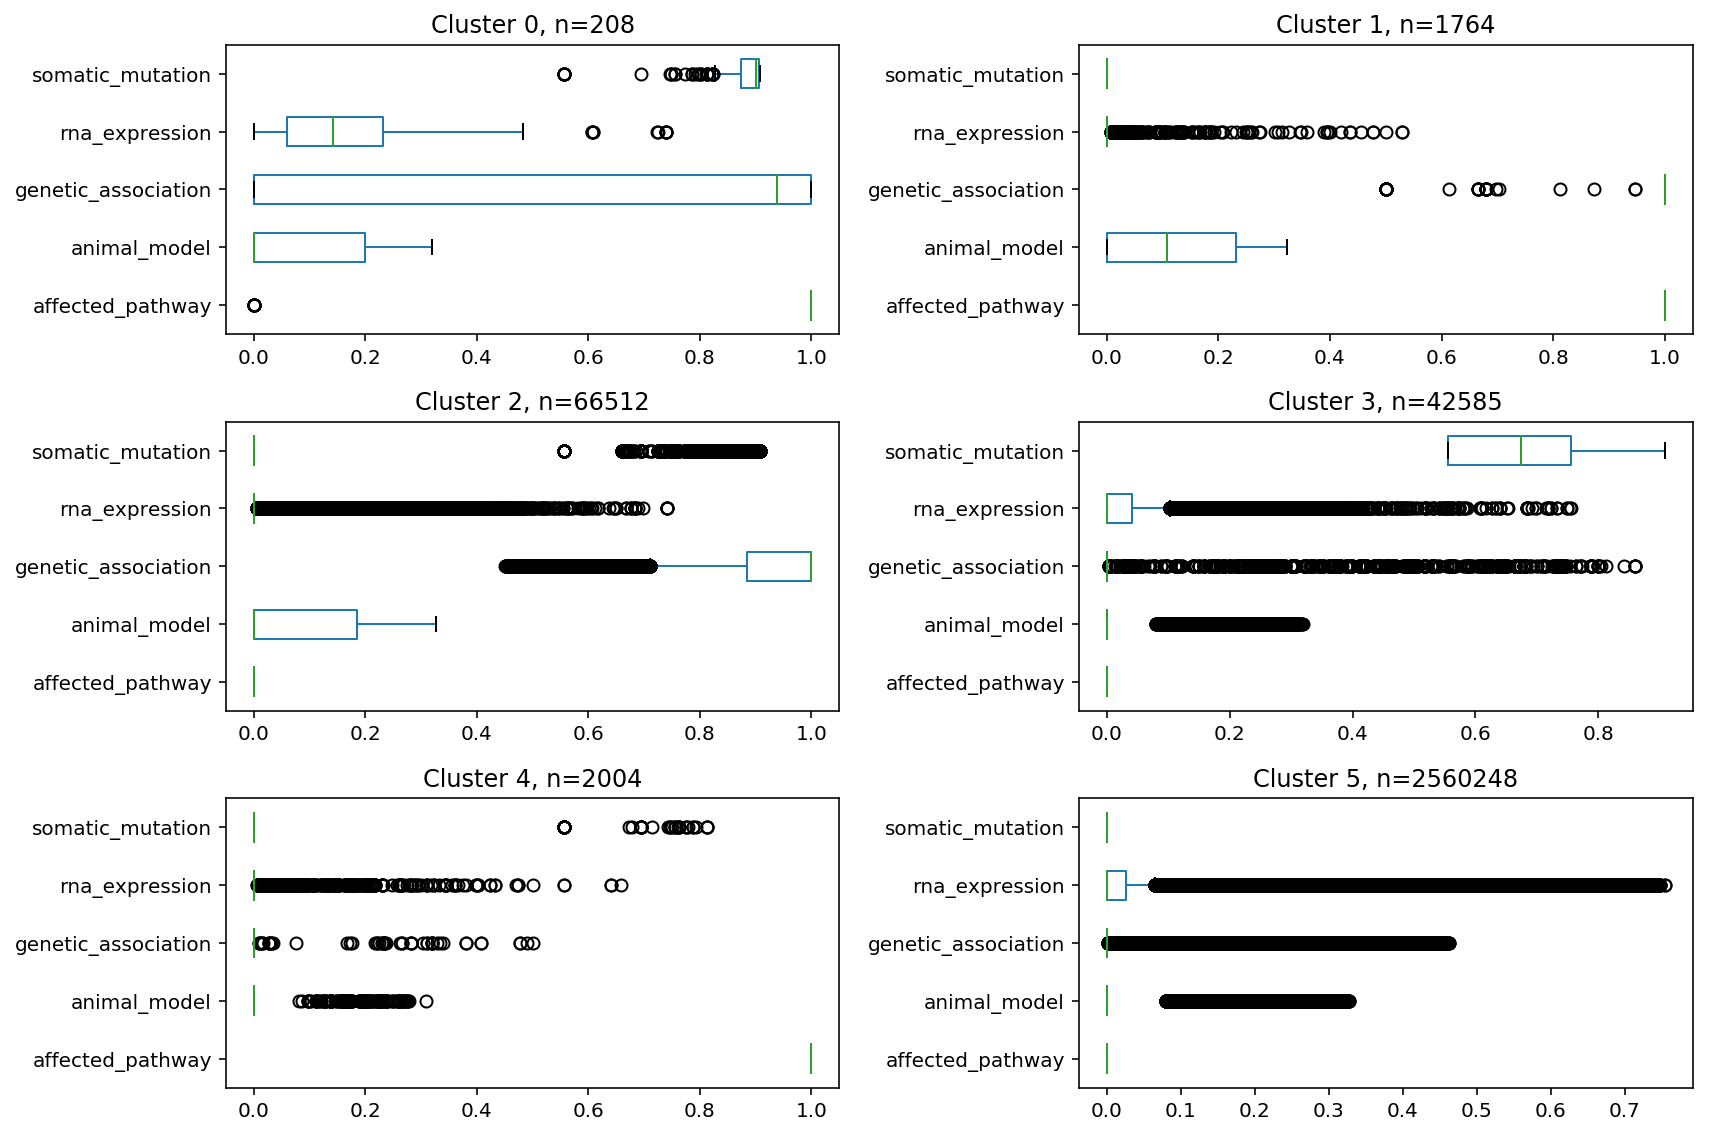

In [9]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,8))
clusters = range(0,6)

gs = GridSpec(3,2)
for c in clusters:
    ax = fig.add_subplot(gs[c])
    df_subset = df_clust[df_clust['clusters'] == c][relevant_cols]
    df_subset.plot(kind='box', ax=ax, vert=False)
    ax.set_title(f'Cluster {c}, n={len(df_subset)}')
plt.tight_layout()

I notice a lot of outliers in some of the plots... but the number of samples per cluster is very different. For example, cluster 5 has a *ton* of outliers, but that's because it's also got the bulk of the samples (2.5 million).

Seeing the other clusters' fingerprints makes me think that there's a lot of samples from cluster5 that could possibly be placed in other clusters, or they could be broken out into their own new cluster (in which case I'd have to change clustering algorithm or explicitly specify more clusters).

Allow myself now to attempt describing what the distributions are "characteristically" looking like, e.g. their "fingerprint".

| Cluster | Somatic Mutation | RNA Expression | Genetic Association | Animal Model | Affected Pathway |
|:-------:|:----------------:|:--------------:|:-------------------:|:------------:|:----------------:|
|    0    |       High       |       Low      |         High        |      Low     |       High       |
|    1    |        Low       |       Low      |         High        |      Low     |       High       |
|    2    |        Low       |       Low      |         High        |      Low     |        Low       |
|    3    |       High       |       Low      |         Low         |      Low     |        Low       |
|    4    |        Low       |       Low      |         Low         |      Low     |       High       |
|    5    |        Low       |       Low      |         Low         |      Low     |        Low       |

Let's take a look at a sampling of gene-disease pairs that are present in each of the clusters.

In [10]:
df_clust[df_clust['clusters'] == 1].groupby('disease').count()

,affected_pathway,animal_model,disease_efo_label,genetic_association,known_drug,literature,rna_expression,somatic_mutation,target,target_id,clusters
disease,,,,,,,,,,,
EFO_0000249,1,1,1,1,1,1,1,1,1,1,1
EFO_0000311,3,3,3,3,3,3,3,3,3,3,3
EFO_0000313,1,1,1,1,1,1,1,1,1,1,1
EFO_0000318,5,5,5,5,5,5,5,5,5,5,5
EFO_0000319,15,15,15,15,15,15,15,15,15,15,15
EFO_0000339,1,1,1,1,1,1,1,1,1,1,1
EFO_0000400,1,1,1,1,1,1,1,1,1,1,1
EFO_0000405,20,20,20,20,20,20,20,20,20,20,20
EFO_0000508,182,182,182,182,182,182,182,182,182,182,182
